# Using Inception_Resnet_v2 model with Tensorflow

In this brief tutorial we will use the [Inception-Resnet-v2](https://arxiv.org/abs/1602.07261) model to extract the features from sample images using TensorFlow library. More information of models implemented in TensorFlow can be found in their [repo](https://github.com/tensorflow/models/tree/master/slim). This model has been developed by Google and is based on Inception v3 and the Microsoft ResNet. The picture below shows the architecture of the Inception-Resnet-v2 model.

![](https://1.bp.blogspot.com/-O7AznVGY9js/V8cV_wKKsMI/AAAAAAAABKQ/maO7n2w3dT4Pkcmk7wgGqiSX5FUW2sfZgCLcB/s1600/image00.png)

## 1. Load images

First of all, we load the images we want to extract the features from. Note that the Inception model requires 299x299 input pictures, thus a resizing step is required before loading the images! Furthermore, the resizing is done so that the aspect ratio is maintained (adding padding).

In [104]:
# Import pillow image libraries and matplotlib to illustrate images
%matplotlib inline
from PIL import Image, ImageChops, ImageOps
from matplotlib import pyplot as plt
# Import libraries to list and create directories
import os 

In [105]:
def load_images(directory):
    images = {}
    for filename in os.listdir(directory):
        if filename.endswith("jpg") or filename.endswith("jpeg") or filename.endswith("JPG") or filename.endswith("JPEG"):
            print("loading", filename, "...")
            total_filename = os.path.join(directory, filename)
            image = Image.open(total_filename)
            images[filename] = image
    return images

We now proceed to load some pictures. For this example, we load the images from the `resized` directory. However, you might want to change this.

In [106]:
directory_load_pictures = 'resized'
images = load_images(directory_load_pictures)

loading 1.jpg ...
loading 2.jpg ...
loading 3.jpg ...
loading 4.jpg ...
loading 5.jpg ...


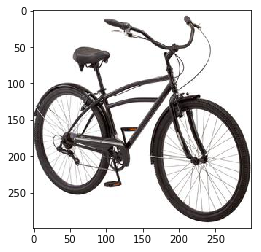

In [107]:
plt.imshow(images['1.jpg'])

## 2. Predict label of image using Inception
Lets get into the interesting stuff! First of all, we need to import some libraries. Note that we are using `inception_resnet_v2` and `inception_preprocessing.py`, which can be found [here](https://github.com/tensorflow/models/blob/master/slim/nets/inception_resnet_v2.py) and [here](https://github.com/tensorflow/models/blob/master/slim/preprocessing/inception_preprocessing.py), respectively. 

In [108]:
import tensorflow as tf
from inception_resnet_v2 import *
from inception_preprocessing import preprocess_for_eval
import numpy as np
import urllib
slim = tf.contrib.slim
import urllib.request
import tarfile

Before using Inception-ResNet model, we need to download the model parameters.

In [109]:
# Download checkpoint for inception-resnet-v2 if not already downloaded
def inception_resnet_v2_maybe_download(checkpoint_file = 'inception_resnet_v2_2016_08_30.ckpt'):
    if not os.path.exists(checkpoint_file):
        if not os.path.exists(checkpoint_file+'.tar.gz'):
            file_url= 'http://download.tensorflow.org/models/inception_resnet_v2_2016_08_30.tar.gz'
            print("Downloading checkpoint...")
            urllib.request.urlretrieve(file_url, checkpoint_file+'.tar.gz')
            r = requests.get(file_url)
        print("Extracting checkpoint...")
        tar = tarfile.open(checkpoint_file+'.tar.gz')
        tar.extractall()
        tar.close()
    else:
        print("Already downloaded and extracted!")
            
checkpoint_file = './inception_resnet_v2_2016_08_30.ckpt'
inception_resnet_v2_maybe_download(checkpoint_file)

Already downloaded and extracted!


### 2.1 Computational Graph & Preprocessing
Tiem to define the placeholders that we will use. Basically we will use one, which will be the gateway for the images to the Inception model. Once images are loaded as tensors, we need to apply some preprocessing (basically, we need to scale values between -1 and 1)

In [116]:
# Dimensions of the pictures
height = 299
width = 299
channels = 3

input_tensor = tf.placeholder(tf.float32, shape=(None,height,width,channels), name='input_image')
scaled_input_tensor = tf.scalar_mul((1.0/255), input_tensor)
scaled_input_tensor = tf.subtract(scaled_input_tensor, 0.5)
scaled_input_tensor = tf.multiply(scaled_input_tensor, 2.0)

### 2.2 Restore Session
In this step, we load the Inception-ResNet-v2 model. Properly speaking, we **restore** the session.

In [111]:
#Load the model
sess = tf.Session()
arg_scope = inception_resnet_v2_arg_scope()
with slim.arg_scope(arg_scope):
    logits, end_points = inception_resnet_v2(scaled_input_tensor, is_training=False)
saver = tf.train.Saver()
saver.restore(sess, checkpoint_file)

We define a dictionary containing human readable categories associated to each label. The original file was obtained from [here](https://gist.github.com/yrevar/6135f1bd8dcf2e0cc683)

In [113]:
import pickle
labels_to_categories = pickle.load(open('imagenet1000_clsid_to_human.pkl', 'rb'))

### 2.3 Evaluate!
Time to predict what classes our pictures belong to and obtain their features using Inception-ResNet-v2 model.

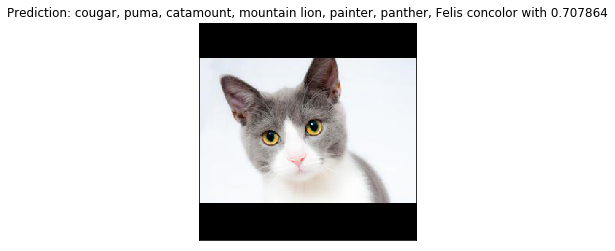

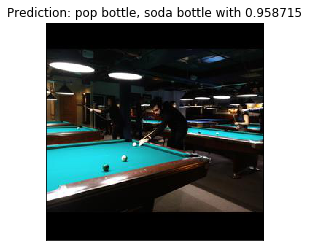

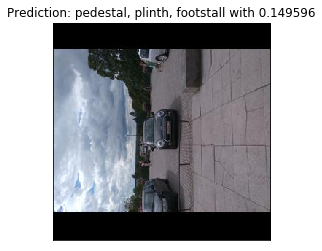

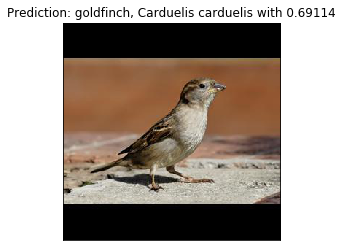

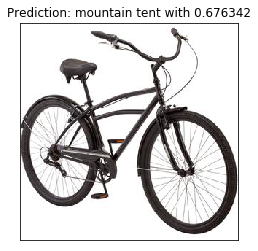

In [114]:
extracted_features = {}
for image_name, image in images.items():
    # Appropriate format for TF
    im = np.array(image)
    im = im.reshape(-1,299,299,3)
    # Obtain prediction (softmax) and logits (last layer scores, i.e. extracted features)
    predict_values, logit_values = sess.run([end_points['Predictions'], logits], feed_dict={input_tensor: im})
    extracted_features[image_name] = logit_values
    
    prediction_name = labels_to_categories[np.argmax(predict_values)]
    confidence = np.max(predict_values)
    #print (np.max(predict_values), np.max(logit_values))
    #print (np.argmax(predict_values), np.argmax(logit_values))
    
    # Plot image with predicted class
    text = 'Prediction: %s with %s' %(prediction_name, confidence)
    img_plot = plt.imshow(image)
    plt.title(text)
    img_plot.axes.get_yaxis().set_ticks([])
    img_plot.axes.get_xaxis().set_ticks([])
    plt.show()

## TODO
1. Store output feature vectors as TFRecords ([ref1](https://kwotsin.github.io/tech/2017/01/29/tfrecords.html))
2. Integrate with resizing process